Time Series Forecasting to Predict Bitcoin Prices

In this notebook, I will be experimenting with two types of RNN architecture. One will be DeepAR, which is a custom RNN network created by AWS. It was also covered in Udacity Machne Learning Engineer Nanodegree. The main RNN architecture will be LSTM. We will experiment with different combination of hidden layers and epoch. Finally the MSE of both of these models will be compared to the results in the benchmark GRU model presented in the paper entitled "A Gated Recurrent Unit Approach to Bitcoin Price Prediction."

The Machine Learning workflow that we will be using will be:
1)Loading and exploring the data
2)Creating training, validation and test sets of time series
3)For DeepAR,we will format the csv to JSON
4)Instantiating and training the DeepAR estimator
5)Deploying the DeepAR model and creaing its predictor
6)Evaluating the predictor for DeepAR
7)Instantiating and training the LSTM estimator
8)Deploying the LSTM model and creaing its predictor
9)Evaluating the predictor for LSTM
10)Comparing the MSE and accuracies for DeepAR v LSTM v GRU 

In [51]:
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd


data = pd.read_csv('./data/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv')
data.isnull().values.any()

True

In [52]:
data.head(20)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1325318220,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1325318280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1325318340,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1325318400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1325318460,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
from datetime import datetime
data.dropna(subset = ["Weighted_Price"], inplace=True)
data.reset_index(drop=True, inplace=True) ##Too many null values so wanted to drop it and reindex


data['date'] = pd.to_datetime(data['Timestamp'],unit='s').dt.date
data.drop(['Timestamp'], axis=1)


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
1,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
2,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
3,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
4,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01
...,...,...,...,...,...,...,...,...
3126475,6847.97,6856.35,6847.97,6856.35,0.125174,858.128697,6855.498790,2020-04-21
3126476,6850.23,6856.13,6850.23,6850.89,1.224777,8396.781459,6855.763449,2020-04-21
3126477,6846.50,6857.45,6846.02,6857.45,7.089168,48533.089069,6846.090966,2020-04-21
3126478,6854.18,6854.98,6854.18,6854.98,0.012231,83.831604,6854.195090,2020-04-21


In [56]:
data.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
1,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
2,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
3,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
4,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01
5,1325431680,4.84,4.84,4.84,4.84,10.000000,48.400000,4.840000,2012-01-01
6,1325457900,5.00,5.00,5.00,5.00,10.100000,50.500000,5.000000,2012-01-01
7,1325534640,5.00,5.00,5.00,5.00,19.048000,95.240000,5.000000,2012-01-02
8,1325591100,5.32,5.32,5.32,5.32,2.419173,12.870000,5.320000,2012-01-03
9,1325600520,5.14,5.14,5.14,5.14,0.680000,3.495200,5.140000,2012-01-03


In [57]:
data.tail(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
3126470,1587513060,6846.26,6851.65,6846.26,6851.65,2.190537,15000.541830,6847.884466,2020-04-21
3126471,1587513120,6841.56,6857.94,6841.56,6857.57,0.341239,2339.346696,6855.456827,2020-04-21
3126472,1587513180,6857.14,6857.14,6850.15,6852.12,2.314358,15854.659703,6850.565383,2020-04-21
3126473,1587513240,6848.09,6848.09,6848.09,6848.09,0.143814,984.851421,6848.090000,2020-04-21
3126474,1587513300,6847.99,6853.04,6847.99,6847.99,3.187161,21825.722306,6848.013005,2020-04-21
3126475,1587513360,6847.97,6856.35,6847.97,6856.35,0.125174,858.128697,6855.498790,2020-04-21
3126476,1587513420,6850.23,6856.13,6850.23,6850.89,1.224777,8396.781459,6855.763449,2020-04-21
3126477,1587513480,6846.50,6857.45,6846.02,6857.45,7.089168,48533.089069,6846.090966,2020-04-21
3126478,1587513540,6854.18,6854.98,6854.18,6854.98,0.012231,83.831604,6854.195090,2020-04-21
3126479,1587513600,6850.60,6850.60,6850.60,6850.60,0.014436,98.896906,6850.600000,2020-04-22


In [58]:
daily_price = data['Weighted_Price'].copy()
print(daily_price.shape)

(3126480,)


In [59]:
daily_price.head()

0    4.390000
1    4.390000
2    4.526411
3    4.580000
4    4.580000
Name: Weighted_Price, dtype: float64

In [47]:
#Selecting Weighted Price and printing shape
print(Daily_Price_df.shape)

(3126480,)


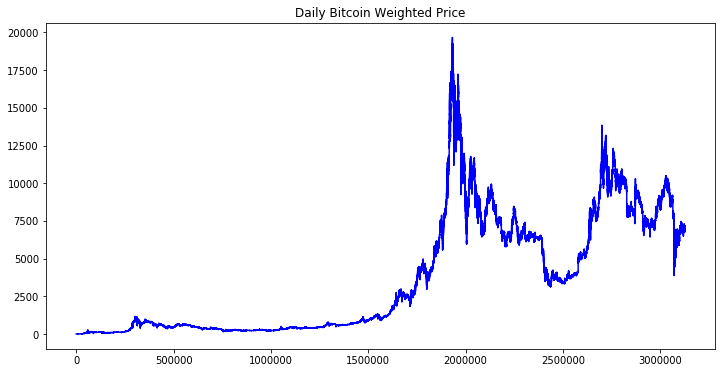

In [60]:
#display the data
plt.figure(figsize=(12,6))
daily_price.plot(title='Daily Bitcoin Weighted Price', color='blue')
plt.show()


In [62]:
group = data.groupby('date')
Daily_Price_mean = group['Weighted_Price'].mean()


In [63]:
def make_time_series(mean_power_df, years, freq='D', start_idx=4):
    '''Creates as many time series as there are complete years. This code
       accounts for the leap year, 2016.
      :param Daily_Price_mean: A dataframe of bitcoin weighted price, averaged by day.
          This dataframe should also be indexed by a datetime.
      :param years: A list of years to make time series out of, ex. ['2013', '2014'].
      :param freq: The frequency of data recording (D = daily)
      :param start_idx: The starting dataframe index of the first point in the first time series.
          The default, 16, points to '2013-01-01'. 
      :return: A list of pd.Series(), time series data.
      '''
    
    # store time series
    time_series = []
    
    # store leap year in this dataset
    leap = '2012'

    # create time series for each year in years
    for i in range(len(years)):

        year = years[i]
        if(year == leap):
            end_idx = start_idx+366
        else:
            end_idx = start_idx+365

        # create start and end datetimes
        t_start = year + '-01-01' # Jan 1st of each year = t_start
        t_end = year + '-12-31' # Dec 31st = t_end

        # get global consumption data
        data = mean_power_df[start_idx:end_idx]

        # create time series for the year
        index = pd.DatetimeIndex(start=t_start, end=t_end, freq=freq)
        time_series.append(pd.Series(data=data, index=index))
        
        start_idx = end_idx
    
    # return list of time series
    return time_series
    

In [65]:
full_years = ['2012', '2013', '2014']
freq='D' # daily recordings

# make time series
time_series = make_time_series(Daily_Price_mean, full_years, freq=freq)

TypeError: __new__() got an unexpected keyword argument 'start'